### Assignment 5 
Implementation of Qlearning and Neural Qlearning

In [47]:
from my_env import EvidenceEnv
import chainer
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer import datasets, iterators, optimizers, serializers
import chainer.training as training
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from chainer import iterators
from chainer.cuda import to_cpu
plt.style.use('ggplot')

Define randomagent. 

In [48]:
class RandomAgent(object):

    def __init__(self, env):
        self.env = env

    def act(self, observation):
        return np.random.choice(self.env.n_action)

    def train(self, a, old_obs, r, new_obs):
        pass        

Run agent

In [49]:
#number of iterations
n_iter = 1000
#environment specs
env = EvidenceEnv(n=2, p=0.95)
#define agent
agent = RandomAgent(env)
#reset environment and agent
obs = env.reset()
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = env.step(action)
    #no training involved for random agent
    agent.train(action, obs, reward, _obs)
    obs = _obs
    reward += r
    R.append(reward)

### Assignment 1 
Plot of the cummulative reward.

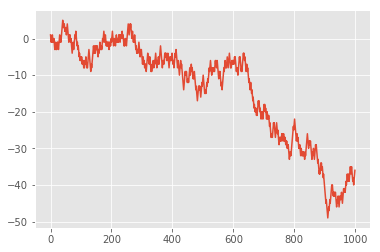

In [50]:
plt.plot(R)
plt.show()

### Assignment 2
Implementation of tabular Q-learning

Plot of the cummulative reward over time.

In [51]:
class TabularAgent(object):

    def __init__(self, env):
        self.env = env
        self.Q = np.random.rand(4,2)
        self.lr = 0.2
        self.gamma = 0.9
        
    def act(self, observation):
        return np.argmax(self.Q[observation,:])
    
    def get_Q(self):
        return np.copy(self.Q)

    def train(self, a, old_obs, r, new_obs):
        old_Q = self.Q[old_obs, a]
        self.Q[old_obs, a] = self.Q[old_obs, a] + \
            self.lr*(r + self.gamma*(self.Q[new_obs, self.act(new_obs)]) - self.Q[old_obs, a])

In [52]:
# number of iterations
n_iter = 1000
#environment specs
tab_env = EvidenceEnv(n=2, p=0.95)
agent = TabularAgent(tab_env)
Q_before = agent.get_Q()
obs = tab_env.asint(env.reset())
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = tab_env.step(action)
    _obs = tab_env.asint(_obs)
    agent.train(action, obs, r, _obs)
    obs = _obs
    reward += r
    R.append(reward)
Q_after = agent.get_Q()

[[ 0.11549449  0.94317128]
 [ 0.47585659  0.18627768]
 [ 0.92994     0.18072901]
 [ 0.49132057  0.37068212]]
[[ 9.19826069  0.01845801]
 [ 8.56754729  0.18627768]
 [ 7.71143213  0.18072901]
 [ 0.28149416  9.16918926]]


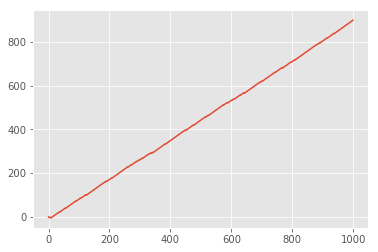

In [53]:
plt.plot(R)
print(Q_before)
print(Q_after)
plt.show()

[[ 0.11549449  0.47585659  0.92994     0.49132057]
 [ 0.94317128  0.18627768  0.18072901  0.37068212]]
[[ 9.19826069  8.56754729  7.71143213  0.28149416]
 [ 0.01845801  0.18627768  0.18072901  9.16918926]]


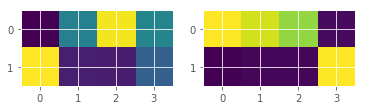

In [54]:
#plot Q values
plt.figure(1)
plt.subplot(121)
plt.imshow(np.transpose(Q_before))

plt.subplot(122)
plt.imshow(np.transpose(Q_after))
plt.show

print np.transpose(Q_before)
print np.transpose(Q_after)


### Assignment 3
Implementation of NeuralQAgent

In [134]:
class NeuralQAgent(object):

    def __init__(self, env, model, classifier, optimizer):
        self.env = env
        self.Q = np.random.rand(4,2)
        self.lr = 0.2
        self.gamma = 0.9
        self.model = model
        self.classifier = classifier
        self.optimizer = optimizer
        
    def act(self, observation):
        return np.argmax(self.Q[observation,:])
    
    def get_Q(self):
        return np.copy(self.Q)

    def train(self, a, old_obs, r, new_obs):
        old_obs, new_obs = np.array(self.env.asbinary(old_obs, 2)), np.array(self.env.asbinary(new_obs, 2))
        classifier.cleargrads()
        predictionMaxQ = np.max(classifier(new_obs.astype('float32')).data)
        Qtarget = r + self.gamma*predictionMaxQ
        targets = np.zeros((self.env.n_action))
        
        targets[a] = Qtarget
        y = classifier(old_obs.astype('float32')).data[1]
        loss = 0.5*F.sum(F.squared_error(y.astype('float32'), targets.astype('float32')))
        loss.backward()
        optimizer.update()

Defining the MLP

In [135]:
class MLP(Chain):
    """
    
    Implementation of a 3-layer Multilayer Perceptron
    
    """
    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, n_units) # Hidden layer
            self.l2 = L.Linear(n_units, n_out) # Output layer
        
    def __call__(self, x):
        h1 = F.relu(self.l1(x))
        output = self.l2(h1)
        return output
  
class Regressor(Chain):
    """

    Regressor chain on top of Neural Network chain 
    for accuracy evaluation and prediction
 
    """
    def __init__(self, predictor):
        super(Regressor, self).__init__()
        with self.init_scope():
            self.predictor = predictor

    def __call__(self, x):
        x = F.expand_dims(x,1)
        y = self.predictor(x)
        #loss = F.mean_squared_error(y, t)
        return y

Training loop.

In [145]:
#number of iterations
n_iter = 1000
#environment specs
env = EvidenceEnv(n=2, p=0.95)
#define agent
model = MLP(2, 2)
classifier = Regressor(model)
optimizer = optimizers.SGD()
optimizer.setup(classifier)
agent = NeuralQAgent(env, model, classifier, optimizer)
#reset environment and agent
Q_before = agent.get_Q()
obs = tab_env.asint(env.reset())
reward = 0
done = False
R = []
for step in range(n_iter):
    env.render
    action = agent.act(obs)
    _obs, r, done, _ = env.step(action)
    _obs = tab_env.asint(_obs)
    agent.train(action, obs, reward, _obs)
    obs = _obs
    reward += r
    R.append(reward)
Q_after = agent.get_Q()

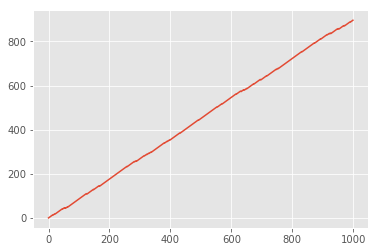

In [146]:
plt.plot(R)
plt.show()

[[ 0.94260088  0.61872913  0.33386864  0.72281122]
 [ 0.81262318  0.25506708  0.92112319  0.87386781]]
[[ 0.94260088  0.61872913  0.33386864  0.72281122]
 [ 0.81262318  0.25506708  0.92112319  0.87386781]]


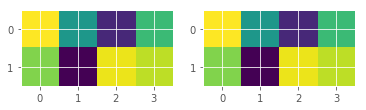

In [147]:
#plot Q values
plt.figure(1)
plt.subplot(121)
plt.imshow(np.transpose(Q_before))

plt.subplot(122)
plt.imshow(np.transpose(Q_after))
plt.show

print np.transpose(Q_before)
print np.transpose(Q_after)